# Vibrational Auto Encoder (VAE) Example
## Description
In this notebook we give an example of **algomorphism** library & **VAE**. More specific we will use MNIST digit Dataset
to create a gif animation. This animation starts with a frame digit from the dataset and ends from other digit as a frame,
all the between frames generated by VAE. To achieve that we train a Convolutional VAE. After training, to generate frames
we create a high dimensional line between embedding vectors of start and end digits. Crossing this line we catch new embeddings
which is not created by any digit of Dataset. Also, we visualize the embedding space in 2D using PCA and 3D using tensorboard.

In [1]:
from algomorphism.base import LossBase, BaseNeuralNetwork, MetricBase
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.animation as animation
from IPython.display import Image
from IPython.core.display import display
from tensorboard.plugins import projector

In [2]:
# for gpu in tf.config.list_physical_devices('GPU'):
#     print(gpu)
#     tf.config.experimental.set_memory_growth(gpu, True)

## Load MNIST Dataset

In [3]:
train, test = tf.keras.datasets.mnist.load_data()
x_train, y_train = train
x_test, y_test = test
x_train = tf.cast(tf.expand_dims(x_train,-1), tf.float32)/255
x_test = tf.cast(tf.expand_dims(x_test, -1), tf.float32)/255

dataset_train = tf.data.Dataset.from_tensor_slices((
    x_train,
    x_train,
    y_train
)).batch(128)

dataset_test = tf.data.Dataset.from_tensor_slices((
    x_test,
    x_test,
    y_test
)).batch(128)



2021-10-15 17:16:35.543200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 17:16:35.564938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 17:16:35.565678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 17:16:35.581862: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
202

## Objects
- DKLl & DKLm: Kullback-Leibler regularization
- Conv2DModule: Conv2D layer, BatchNormalization, PReLU
- Conv2DTransposeModule: Conv2DTranspose layer, BatchNormalization, PReLU
- Sampling: add bellow of Conv2DModule to random generate embeddings
- Encoder: VEA Encoder, a stuck of 2 Conv2DModule and Sampling layer
- Decoder: VEA Decoder, a stuck of 2 Conv2DTransposeModule
- VAE: Vibrational Auto Encoder trainable object

In [4]:
class DKLl(object):
    def __init__(self):
        pass

    def __call__(self, y_true, y_pred):
        y_, z_mean, z_log_var =  y_pred
        loss = tf.keras.losses.binary_crossentropy(y_true, y_)
        loss = tf.reduce_mean(loss, axis= [1,2])
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss, axis=-1)
        loss = loss + kl_loss
        return tf.reduce_mean(loss)

class DKLm(tf.keras.metrics.Metric):
    def __init__(self):
        super(DKLm, self).__init__(name='dklm')
        self.__mean = tf.keras.metrics.Mean()

    def update_state(self, y_true, y_pred):
        y_, z_mean, z_log_var =  y_pred
        loss = tf.keras.metrics.binary_crossentropy(y_true, y_)
        loss = tf.reduce_mean(loss, axis=[1,2])

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss, axis=-1)
        loss = loss + kl_loss
        self.__mean.update_state(loss)

    def result(self):
        results = self.__mean.result().numpy()
        return results

    def reset_states(self):
        self.__mean.reset_state()

class Conv2DModule(tf.keras.layers.Layer):
    def __init__(self, n_channels, kernel_size):
        super(Conv2DModule, self).__init__(name='conv2dmodule')

        self.conv = tf.keras.layers.Conv2D(n_channels, kernel_size, strides=2, padding='same')
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.prelu = tf.keras.layers.PReLU()

    def call(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        y = self.prelu(x)
        return y

class Conv2DTransposeModule(tf.keras.layers.Layer):
    def __init__(self, n_channels, kernel_size):
        super(Conv2DTransposeModule, self).__init__(name='conv2d_tr_module')

        self.convtr = tf.keras.layers.Conv2DTranspose(n_channels, kernel_size, strides=2, padding='same')
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.prelu = tf.keras.layers.PReLU()

    def call(self, x):
        x = self.convtr(x)
        x = self.batchnorm(x)
        y = self.prelu(x)
        return y

class Sampling(tf.keras.layers.Layer):
    """
    References:
        https://keras.io/examples/generative/vae/
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(Model):
    def __init__(self):
        Model.__init__(self, name="encoder")

        self.cnn1 = Conv2DModule(64, 3)
        self.cnn2 = Conv2DModule(128, 3)

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')

        self.z_mean = tf.keras.layers.Dense(128)
        self.z_log_var = tf.keras.layers.Dense(128)

        self.z = Sampling()

    def call(self, input):
        x = self.cnn1(input)
        x = self.cnn2(x)
        x = self.flatten(x)
        x = self.fc1(x)

        z_mean = self.z_mean(x)
        z_log_var= self.z_log_var(x)
        z = self.z([z_mean, z_log_var])

        return z, z_mean, z_log_var


class Decoder(Model):
    def __init__(self):
        Model.__init__(self, name="decoder")

        self.fc1 = tf.keras.layers.Dense(7*7*256, activation='relu')
        self.reshape = tf.keras.layers.Reshape((7,7,256))
        self.cnnt1 = Conv2DTransposeModule(128, 3)
        self.cnnt2 = Conv2DTransposeModule(64, 3)
        self.out = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')

    def call(self, input):
        x = self.fc1(input)
        x = self.reshape(x)
        x = self.cnnt1(x)
        x = self.cnnt2(x)
        y = self.out(x)
        return y


class VAE(Model, BaseNeuralNetwork):
    def __init__(self, early_stop_vars=None, weights_outfile=None, optimizer="Adam", learning_rate=1e-4):
        Model.__init__(self, name="vae")

        status = [
            [0],
            [1,2]
        ]
        BaseNeuralNetwork.__init__(self, status, early_stop_vars, weights_outfile, optimizer, learning_rate)


        self.cost_mtr = MetricBase(self,
                                   [DKLm()],
                                   status,
                                   [0],
                                   1
                                   )

        self.cost_loss = LossBase(self,
                                  [DKLl()],
                                  status,
                                  [0]
                                  )
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs):

        z, z_mean, z_log_var = self.encoder(inputs[0])
        y = self.decoder(z)

        return [[y, z_mean, z_log_var]]

    def get_rec_out(self, input):
        z, _, _ = self.encoder(input)
        y = self.decoder(z)
        return y

## Initialize & Train VAE

In [5]:
vae = VAE(optimizer='Adam')

In [6]:
vae.train(dataset_train, 50, dataset_test)

2021-10-15 17:16:36.947540: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.
2021-10-15 17:16:37.154264: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.
2021-10-15 17:16:38.260195: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


Epoch 1 finished


2021-10-15 17:17:10.369901: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.
2021-10-15 17:17:10.589994: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
train_cost: 0.268670916557312
val_cost: 0.26868900656700134
Epoch 2 finished
train_cost: 0.2498040795326233
val_cost: 0.250137597322464
Epoch 3 finished
train_cost: 0.24533480405807495
val_cost: 0.24458637833595276
Epoch 4 finished
train_cost: 0.2424585074186325
val_cost: 0.2420538365840912
Epoch 5 finished
train_cost: 0.24125267565250397
val_cost: 0.24037733674049377
Epoch 6 finished
train_cost: 0.2400626689195633
val_cost: 0.2397923767566681
Epoc

## Visualization
### VAE input, output example

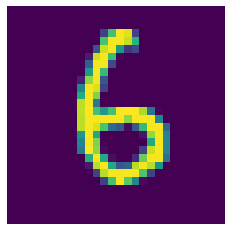

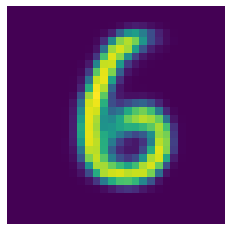

In [7]:
i = tf.where(y_test == 6)[1,0]

nx = x_test[i]
plt.figure()
plt.imshow(nx)
plt.axis('off')
plt.figure()
plt.axis('off')
plt.imshow(vae.get_rec_out(tf.reshape(nx, (1, *nx.shape)))[0])


### Creation of 0 to 6 animation/gif
The animation rate change via sigmoid function:
<br>
$
sigmoid(t) = \frac{1}{1+e^{-t}} \quad (1).
$
<br>
Lets assume $z_l$ the embeding of 0 frame and $z_r$ the embedding of 6 frame the line $z$ between embeddings throw time is:
<br>
$
z(t) = z_r(1-t) + z_l t \quad (2).
$
<br>
From $(1), (2)$ we have the final $z$ function:
<br>
$
z(t) = \frac{z_re^{-t}+z_l}{1+e^{-t}} \quad (3).
$
<br>

MovieWriter imagemagick unavailable; using Pillow instead.


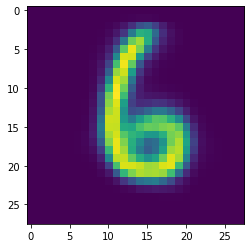

In [8]:
a = np.linspace(-10,10,200)
a = 1/(1+np.exp(-a))

il = tf.where(y_test == 0)[1, 0]
ir = tf.where(y_test == 6)[1, 0]

zl, _, _ = vae.encoder(tf.reshape(x_test[il], (1, 28,28,1)))
zr, _, _ = vae.encoder(tf.reshape(x_test[ir], (1, 28,28,1)))


fig = plt.figure()
frames = []

for i in a:
    z = zl*(1-i) + i*zr
    y = vae.decoder(z)
    y = tf.squeeze(y)
    frames.append([plt.imshow(y)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                        repeat_delay=500)
ani.save('from_0_to_6.gif', writer='imagemagick')

### Play animation

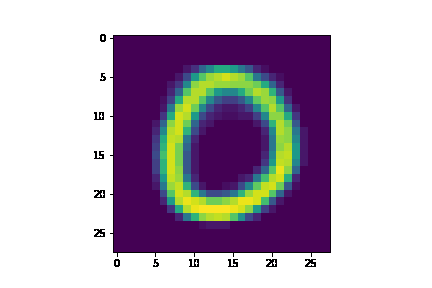

In [9]:
with open('from_0_to_6.gif','rb') as f:
    display(Image(data=f.read(), format='png'))


### Plot PCA 2D embedding space

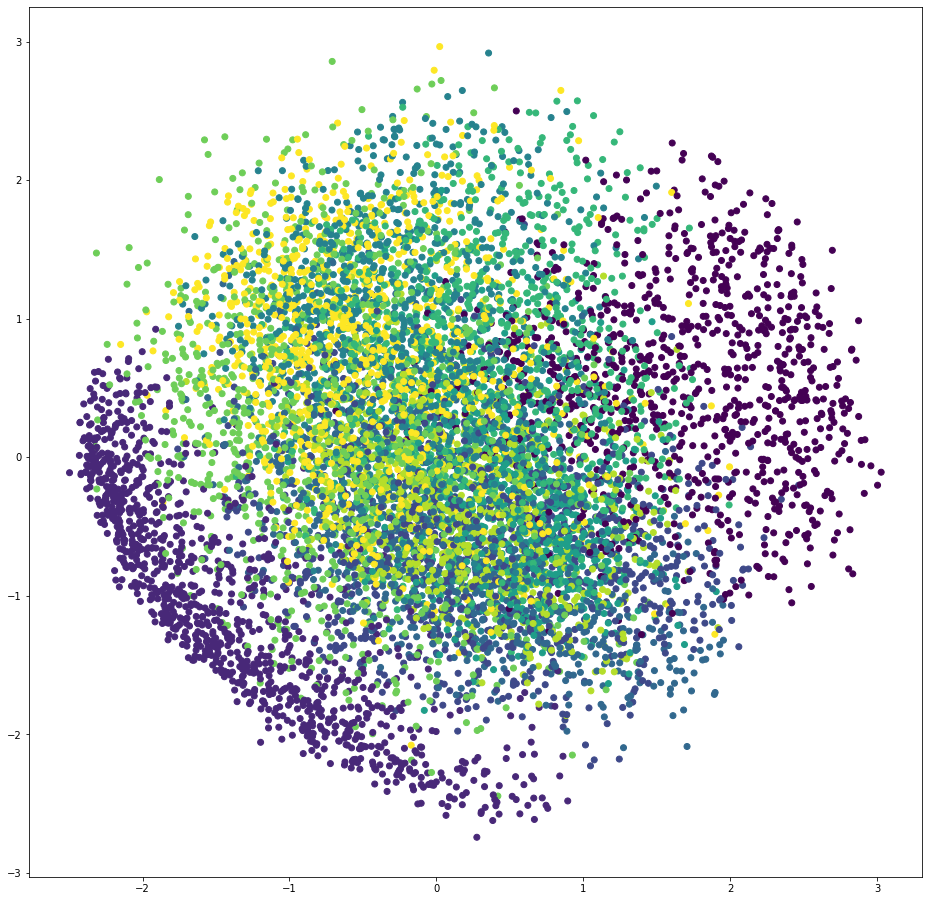

In [10]:
plt.figure(figsize=(16,16))
Z = []
i = 0
for x, _, _ in dataset_test:
    z, z_mean, z_log = vae.encoder(x)
    Z.append(z_mean)
    i += 1
Z = tf.concat(Z, axis=0)
pca_z  = PCA(2).fit_transform(tf.concat(Z, axis=0))

plt.scatter(pca_z[:, 0], pca_z[:, 1], c=y_test)


### Play around with tensorboard projector for 3D embedding sapce

In [11]:
set = [str(i) for i in range(10)]

import os
labels_enum = [
    [set[l], str(i)] for i, l in enumerate(y_test)
]
log_dir="./tensorboard_files/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
! rm tensorboard_files/*
out = 'foo.tsv'
with open(os.path.join(log_dir, out), "w") as f:
    text = "idx\tlabel\n"
    for i, c in enumerate(labels_enum):
        text += '\t'.join(c)
        text += '\n'
    f.write(text)
    f.close()

In [12]:
%load_ext tensorboard
%reload_ext tensorboard

weights = tf.Variable(Z)

checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()

# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"

# set tsv file
embedding.metadata_path = out

projector.visualize_embeddings(log_dir, config)



## References
- Keras VAE: [https://keras.io/examples/generative/vae/](https://keras.io/examples/generative/vae/)
- DKL code: [https://github.com/tkipf/gae/blob/master/gae/optimizer.py](https://github.com/tkipf/gae/blob/master/gae/optimizer.py)
- $z$ line, "Deep Feature Consistent Variational Autoencoder": [https://arxiv.org/pdf/1610.00291.pdf](https://arxiv.org/pdf/1610.00291.pdf)

### Run TensorBoard

In [13]:
%tensorboard --logdir=./tensorboard_files/ --host localhost --port 8882

Launching TensorBoard...